#Install dependencies

In [35]:
!pip install datasets torchvision torch seaborn --quiet

#Imports and Setup

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load Stanford Cars Dataset

In [ ]:
dataset = load_dataset("tanganke/stanford_cars")
train_dataset = dataset['train']
test_dataset = dataset['test']
label_names = train_dataset.features['label'].names

#Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image.convert("RGB"))
        return image, label

train_data = CarDataset(train_dataset, transform)
test_data = CarDataset(test_dataset, transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

#Define EfficientNet Model

In [ ]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 196)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training Loop

In [ ]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.2f} - Train Accuracy: {100 * correct / total:.2f}%")

Epoch 1/5 - Loss: 939.08 - Train Accuracy: 19.17%
Epoch 2/5 - Loss: 360.84 - Train Accuracy: 60.52%
Epoch 3/5 - Loss: 166.53 - Train Accuracy: 81.18%
Epoch 4/5 - Loss: 95.94 - Train Accuracy: 88.81%
Epoch 5/5 - Loss: 63.63 - Train Accuracy: 92.85%


#Evaluation and Metrics

In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.cpu().tolist())

#Print full classification report (can be long)

In [ ]:
print("\nClassification Report (All Classes):")
print(classification_report(y_true, y_pred, target_names=label_names))


Classification Report (All Classes):
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.45      1.00      0.62        44
                                   Acura RL Sedan 2012       0.35      0.81      0.49        32
                                   Acura TL Sedan 2012       0.75      0.63      0.68        43
                                  Acura TL Type-S 2008       0.76      0.93      0.84        42
                                  Acura TSX Sedan 2012       0.61      0.78      0.68        40
                             Acura Integra Type R 2001       0.90      0.59      0.71        44
                              Acura ZDX Hatchback 2012       0.86      0.64      0.74        39
              Aston Martin V8 Vantage Convertible 2012       0.59      0.29      0.39        45
                    Aston Martin V8 Vantage Coupe 2012       0.63      0.46      0.54        41
 

#Confusion Matrix (10 classes only)

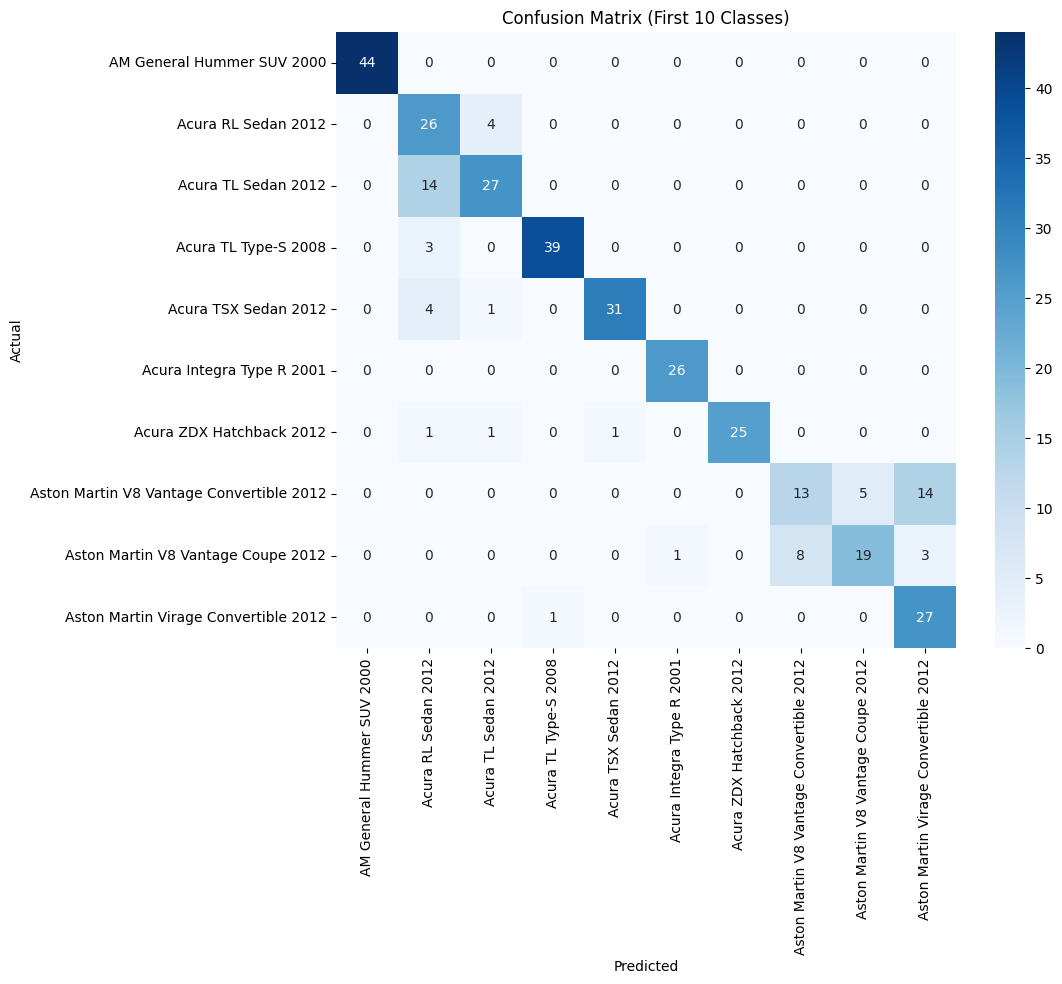

In [28]:
subset_labels = list(range(10))
filtered_true = [y for y in y_true if y in subset_labels]
filtered_pred = [p for y, p in zip(y_true, y_pred) if y in subset_labels]

cm = confusion_matrix(filtered_true, filtered_pred, labels=subset_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names[:10], yticklabels=label_names[:10], cmap="Blues")
plt.title("Confusion Matrix (First 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Sample Predictions Visualization

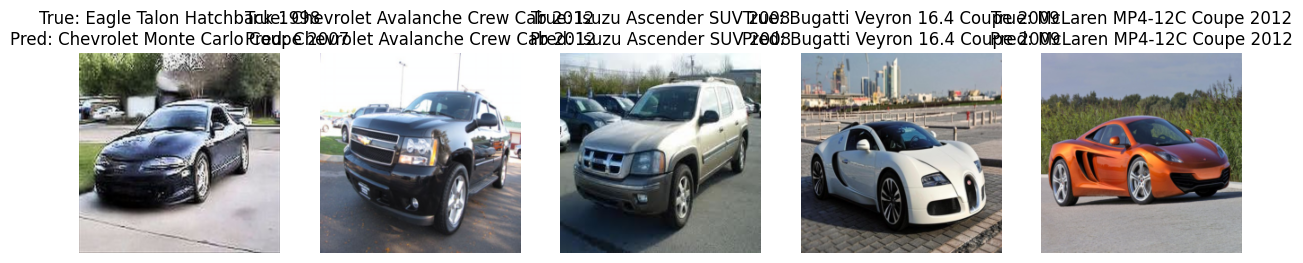

In [34]:
def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

model.eval()
samples = random.sample(range(len(test_data)), 5)
plt.figure(figsize=(15, 6))
for i, idx in enumerate(samples):
    image, label = test_data[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    plt.subplot(1, 5, i+1)
    imshow(image, f"True: {label_names[label]}\nPred: {label_names[pred.item()]}")
plt.show()